<a href="https://colab.research.google.com/github/Beatriz-Yun/AIFFEL_LMS/blob/main/Exploration/%5BE-08%5Dsemantic_segmentation%EC%9C%BC%EB%A1%9C_%EC%97%AC%EB%9F%AC%EC%8B%9C%EB%8F%84%ED%95%B4%EB%B3%B4%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 인물모드 적용

## (1) 사진 불러오기
- 내 사진
- 고양이 사진
- 배경 사진

In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
img_path = '/content/drive/MyDrive/Colab Notebooks/AIFFEL_LMS/data/'

img1 = cv2.imread(img_path+'sehui2.jpg')
img2 = cv2.imread(img_path+'bari.jpg')
img3 = cv2.imread(img_path+'background.jpg')

print (img1.shape)
print (img2.shape)
print (img3.shape)

(1279, 1279, 3)
(3024, 4032, 3)
(3024, 4032, 3)


## (2) DeepLab 모델

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = '/content/drive/MyDrive/Colab Notebooks/AIFFEL_LMS/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /content/drive/MyDrive/Colab Notebooks/AIFFEL_LMS/human_segmentation/models
model loaded successfully!


## (3) 이미지resize 및 원하는 객체 mask

입력: 이미지, 레이블<br>
출력: 검출한 이미지

In [7]:
def resize_and_mask(img, label):
  img_resized, seg_map = MODEL.run(img)
  print (img.shape, img_resized.shape, seg_map.max())

  img_show = img_resized.copy()
  seg_map = np.where(seg_map == label, label, 0)    # 원하는 객체만 추출
  img_mask = seg_map * (255/seg_map.max()) # 255 normalization
  img_mask = img_mask.astype(np.uint8)
  color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
  img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

  plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
  plt.show()

  return img_mask

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv']이므로

<br>

label은 각각 cat은 8, person은 15이다.

(1279, 1279, 3) (513, 513, 3) 15


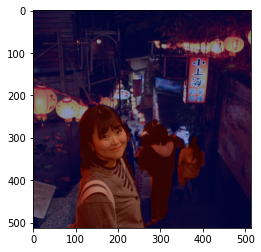

In [8]:
img1_mask = resize_and_mask(img1, 15)

In [ ]:
img1_mask.shape

(513, 513)

(3024, 4032, 3) (384, 513, 3) 8


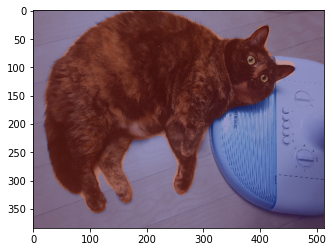

In [9]:
img2_mask = resize_and_mask(img2, 8)

## (4) original size mask와 deeplab model mask(resize된 이미지) 비교

In [14]:
def compare_masks(img, img_mask):
  img_mask_up = cv2.resize(img_mask, img.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
  _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

  ax = plt.subplot(1,2,1)
  plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
  ax.set_title('Original Size Mask')

  ax = plt.subplot(1,2,2)
  plt.imshow(img_mask, cmap=plt.cm.binary_r)
  ax.set_title('DeepLab Model Mask')

  plt.show()

  return img_mask_up

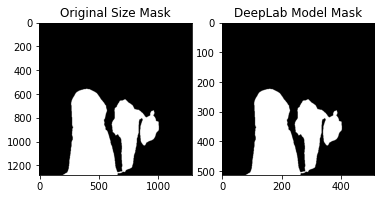

In [15]:
img1_mask_up = compare_masks(img1, img1_mask)

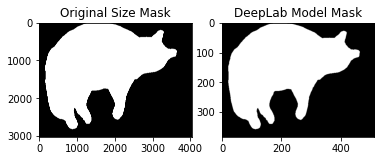

In [16]:
img2_mask_up = compare_masks(img2, img2_mask)

## (5) 이미지를 흐리게 한 뒤 배경만 추출

In [36]:
def blur_mask_background(img, img_mask_up):
  img_orig_blur = cv2.blur(img, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
  img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
  img_bg_mask = cv2.bitwise_not(img_mask_color)
  img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
  plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
  plt.show()

  return img_mask_color, img_bg_blur

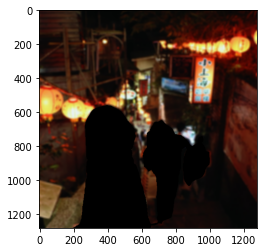

In [37]:
img1_mask_color, img1_bg_blur = blur_mask_background(img1, img1_mask_up)

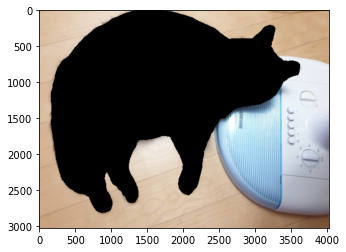

In [38]:
img2_mask_color, img2_bg_blur = blur_mask_background(img2, img2_mask_up)

## (6) 배경과 객체 이미지 합치기

In [40]:
def img_concat(img, img_mask_color, img_bg_blur):
  img_concat = np.where(img_mask_color==255, img, img_bg_blur)
  plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
  plt.show()

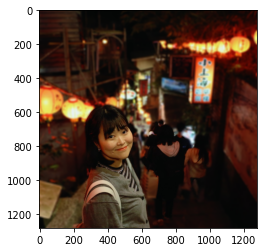

In [41]:
img_concat(img1, img1_mask_color, img1_bg_blur)

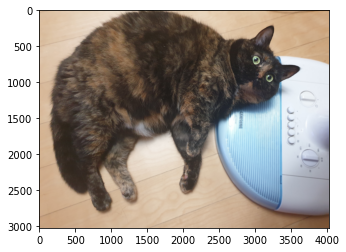

In [42]:
img_concat(img2, img2_mask_color, img2_bg_blur)

## (7) 다른 배경 적용하기

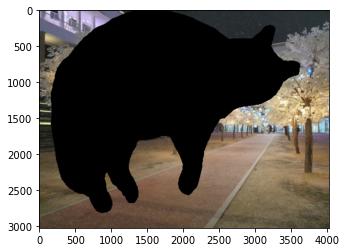

In [44]:
img3_mask_color, img3_bg_blur = blur_mask_background(img3, img2_mask_up)

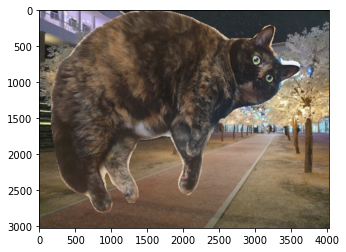

In [46]:
img_concat(img2, img3_mask_color, img3_bg_blur)

img1과 배경이미지 img3은 크기가 달라서 합쳐지지 않는다.

In [47]:
img3_mask_color, img3_bg_blur = blur_mask_background(img3, img1_mask_up)

error: ignored

이미지를 합치기 전에 resize하는 동작을 함수에 추가해준다.

<br>

형준님의 도움을 받아 이미지의 크기가 작은쪽으로 resize하는 방법과 cv2.copyMakeBorder를 사용하는 방법을 활용했다.

In [66]:
def img_blur_resize_concat(img, bg_img, img_mask, save_name='ex8_result', ratio=0.5, borderType=cv2.BORDER_REFLECT):
  original_h, original_w = img.shape[:2]  # cv2.imread()로 읽어와 height와 width를 저장합니다
  bg_h, bg_w = bg_img.shape[:2]

  if (bg_h/original_h) >= (bg_w/original_w):  # 원본 이미지를 배경 이미지의 height와 width 중 배경/원본이 작은 쪽으로 맞춥니다. 
            # 원본 이미지: (960, 540), 배경 이미지: (1260, 1080)  ->  세로 비: 1260 / 960 = 1.3125, 가로 비: 1080 / 540 = 2 -> 가로 쪽에 맞춥니다.
            # 변환 후 이미지 : (1260, 709)
      resize_shape = (int(original_h * bg_w / original_w), bg_w)[::-1]  # cv2.resize에 인자로 넣을 것이므로
  else:
      resize_shape = (bg_h, int(original_w * bg_h / original_h))[::-1]  # 가로, 세로 순서로 넣어주어야 합니다

  img_mask_up = cv2.resize(img_mask, resize_shape, interpolation=cv2.INTER_LINEAR)  # mask와 원본 이미지를 모두 배경에 맞춰 resize합니다
  img_orig_up = cv2.resize(img, resize_shape, interpolation=cv2.INTER_LINEAR)

  resized_w, resized_h = resize_shape  # 가로, 세로 중 한 쪽은 배경 이미지와 동일합니다
  width_diff = bg_w - resized_w  # 배경 이미지와 변환 후 이미지의 가로 차이입니다
  height_diff = bg_h - resized_h  # 배경 이미지와 변환 후 이미지의 세로 차이입니다

  top_padding = int(height_diff * ratio)  # 원본 이미지에서 잘라낸 부분을 정 중앙에 두기 위해 양쪽에 같은 패딩을 줍니다
  left_padding = int(width_diff * ratio)  # 원본 이미지에서 잘라낸 부분을 정 중앙에 두기 위해 양쪽에 같은 패딩을 줍니다
  _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

  # top, bottom, left, right
  img_mask_up = cv2.copyMakeBorder(img_mask_up, top_padding, height_diff-top_padding, left_padding, width_diff-left_padding, borderType, value=0)
  img_orig_up = cv2.copyMakeBorder(img_orig_up, top_padding, height_diff-top_padding, left_padding, width_diff-left_padding, borderType, value=0)
  img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)

  plt.imshow(img_mask_color) # 마스크 시각화
  plt.show()

  bg_img_blur = cv2.blur(bg_img, (13, 13)) # blurring  kernel size를 뜻합니다. 
  bg_img_mask = cv2.bitwise_not(img_mask_color)
  bg_img_blur = cv2.bitwise_and(bg_img_blur, bg_img_mask)

  # 배경과 합치기
  img_concat = np.where(img_mask_color==255, img_orig_up, bg_img_blur)
  plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
  plt.show()

  # 결과물 저장
  cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/AIFFEL_LMS/data/'+save_name+'.jpg', img_concat)


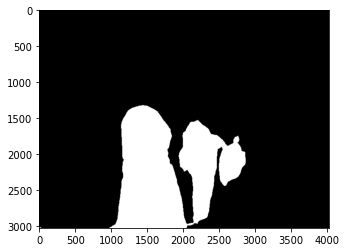

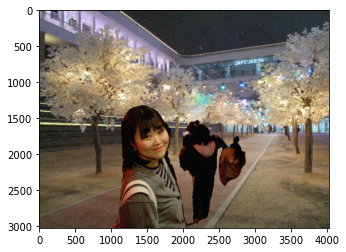

In [67]:
img_blur_resize_concat(img1, img3, img1_mask, save_name='result1')

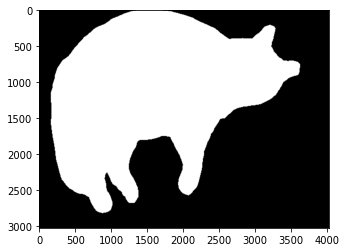

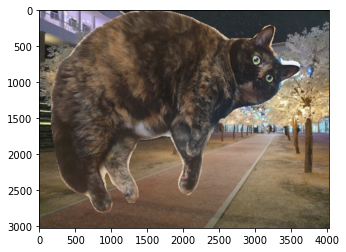

In [68]:
img_blur_resize_concat(img2, img3, img2_mask, save_name='result2')

### 제작한 인물모드 사진들에서 나타나는 문제점
![이미지](https://drive.google.com/uc?export=view&id=1KIUCk4qPBO984hKMerVlt3lplaQgzwm-)

![이미지](https://drive.google.com/uc?export=view&id=1Sswfx2O6_2fNUMWDrtO2otZS9ArF9JKQ)


# 루브릭

1.인물모드 사진을 성공적으로 제작하였다.
- 아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.
2.제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.
- 인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.
3.인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.
- 추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다.

# 회고

첫 번째 사진에서 의미있는 사람 객체는 가장 큰 객체인데, semantic segmentation은 같은 클래스의 객체들은 구분하지 않기 때문에 같이 mask되었다. 사람 중에서도 원하는 객체만 골라내는 instance segmentation이 이런 상황에 필요하겠다는 것을 느꼈다.